In [104]:
!pip install langgraph

In [105]:
#from langgraph.graph import Graph
from langgraph.graph import StateGraph, END
from dotenv import load_dotenv
load_dotenv()
from typing import TypedDict, List
import os

langgraph->orchestration->pipeline

langgraph->nodes,edges,State

node->funtions

edges-> connectivity between nodes(funtions)

In [81]:
"""   
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro")
"""   

'   \nfrom langchain_google_genai import GoogleGenerativeAIEmbeddings\nembeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")\nfrom langchain_google_genai import ChatGoogleGenerativeAI\nllm = ChatGoogleGenerativeAI(model="gemini-1.5-pro")\n'

#### Alternate with OpenAI:

In [106]:
from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

In [107]:
llm.invoke("hi").content

'Hello! How can I assist you today?'

In [72]:
"""   
def LLM(input):
    llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro")
    response=llm.invoke(input).content
    return response
"""

'   \ndef LLM(input):\n    llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro")\n    response=llm.invoke(input).content\n    return response\n'

#### Alternate with OpenAI:

In [ ]:
""" 
def LLM(input):
    llm = ChatOpenAI(model="gpt-4o")
    response=llm.invoke(input).content
    return response
""" 

## Function/Node 1:

In [108]:
from langchain_core.messages import HumanMessage

# Define the LLM node function
def LLM(state: AgentState) -> AgentState:
    # Initialize the LLM (e.g., OpenAI model)
    llm = ChatOpenAI(model="gpt-4o")
    
    # Extract the latest message from the state
    input_message = state["messages"][-1]
    
    # Call the LLM with the input message wrapped as a HumanMessage
    response = llm.invoke([HumanMessage(content=input_message)])
    
    # Extract the response content (string) from the LLM output
    llm_output = response.content
    
    # Return the updated state
    return {"messages": state["messages"] + [llm_output]}

In [73]:
""" 
def Counter_Token(input):
    token=input.split()
    token_number=len(token)
    response=f"total number of token in the generated output {token_number}"
    return response
 """    

' \ndef Counter_Token(input):\n    token=input.split()\n    token_number=len(token)\n    response=f"total number of token in the generated output {token_number}"\n    return response\n '

## Function/Node 2:

In [109]:
# Define the Token Counter node function
def Counter_Token(state: AgentState) -> AgentState:
    # Extract the latest message (LLM output)
    text = state["messages"][-1]
    
    # Simple token count (split by whitespace)
    token_count = len(text.split())
    
    # Return the updated state Verbose
    return {"messages": state["messages"] + [f"Total number of token in the generated output {token_count}"]}

## Create a Graph:

In [86]:
#workflow=Graph()

In [110]:
# Define the state schema for StateGraph
class AgentState(TypedDict):
    messages: List[str]

# Initialize the StateGraph
workflow = StateGraph(AgentState)

In [111]:
# Add nodes
workflow.add_node("MY LLM",LLM)

In [112]:
# Add nodes
workflow.add_node("Token Counter",Counter_Token)

In [113]:
# Add edges
workflow.add_edge("MY LLM", "Token Counter")

In [114]:
# Add edges
workflow.set_entry_point("MY LLM")
workflow.set_finish_point("Token Counter")

In [115]:
# Compile the workflow
app=workflow.compile()

In [116]:
from IPython.display import Image, display

In [117]:
app.get_graph()

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnableCallable(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'MY LLM': Node(id='MY LLM', name='MY LLM', data=MY LLM(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'Token Counter': Node(id='Token Counter', name='Token Counter', data=Token Counter(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=None, metadata=None)}, edges=[Edge(source='MY LLM', target='Token Counter', data=None, conditional=False), Edge(source='__start__', target='MY LLM', data=None, conditional=False), Edge(source='Token Counter', target='__end__', data=None, conditional=False)])

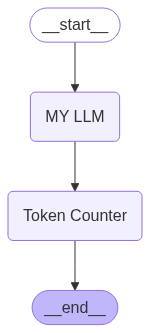

In [118]:
display(Image(app.get_graph().draw_mermaid_png())) 

In [100]:
#app.invoke("what is a agentic ai explain me in very detailed manner?")

## Invoke Output:

In [119]:
# Corrected invoke call
result = app.invoke({"messages": ["what is a agentic ai explain me in very detailed manner?"]})
print(result["messages"][-1])  # Prints the final output (e.g., token count)

Total number of token in the generated output 550


## Stream Output:

In [125]:
for output in app.stream({"messages": ["what is a agentic ai explain me in very detailed manner?"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value["messages"][-1])
        print("\n")

here is output from MY LLM
_______
Agentic AI refers to artificial intelligence systems that exhibit, to some extent, autonomous decision-making and action capabilities in their environment. These systems can perceive their surroundings, process information, make decisions based on predefined goals, and execute actions without constant human oversight or direct input.

**Detailed Explanation:**

1. **Autonomy:**
   - **Definition:** Autonomy in AI refers to the system's ability to operate independently from human intervention, once it has been given initial instructions or objectives.
   - **Capabilities:** Agentic AI can assess situations and determine which actions to take to achieve specific goals. This requires a level of decision-making ability comparable to that of an agent acting in an environment.

2. **Perception and Cognition:**
   - **Sensors and Data Collection:** These AI systems use sensors and data input mechanisms to gather information about their environment. This inpu

In [126]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [30]:
loader=DirectoryLoader("../data",glob="./*.txt",loader_cls=TextLoader)
docs=loader.load()
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=200
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

In [31]:
doc_strings

['Madam Speaker, Madam Vice President, our First Lady and Second Gentleman. Members of Congress and the Cabinet. Justices of the Supreme Court. My fellow Americans.  \n\nLast year COVID-19 kept us apart. This year we are finally together again. \n\nTonight, we meet as Democrats Republicans and Independents. But most importantly as Americans. \n\nWith a duty to one another to the American people to the Constitution. \n\nAnd with an unwavering resolve that freedom will always triumph over tyranny.',
 'With a duty to one another to the American people to the Constitution. \n\nAnd with an unwavering resolve that freedom will always triumph over tyranny. \n\nSix days ago, Russia’s Vladimir Putin sought to shake the foundations of the free world thinking he could make it bend to his menacing ways. But he badly miscalculated. \n\nHe thought he could roll into Ukraine and the world would roll over. Instead he met a wall of strength he never imagined. \n\nHe met the Ukrainian people.',
 'He tho

In [32]:
db = Chroma.from_documents(new_docs, embeddings)

retriever = db.as_retriever(search_kwargs={"k": 3})

In [ ]:
db = Chroma.from_documents(new_docs, embeddings)

retriever = db.as_retriever(search_kwargs={"k": 3})

query = "why scientist was working hard for what kind of vaccines?"
docs = retriever.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)

C:\Users\sunny\AppData\Local\Temp\ipykernel_79328\1463751420.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(query)


{'source': '..\\data\\state_of_the_union.txt'}
The scientists are working hard to get that done and we’ll be ready with plenty of vaccines when they do. 

We’re also ready with anti-viral treatments. If you get COVID-19, the Pfizer pill reduces your chances of ending up in the hospital by 90%.  

We’ve ordered more of these pills than anyone in the world. And Pfizer is working overtime to get us 1 Million pills this month and more than double that next month.


In [34]:
for doc in docs:
    print(doc)

page_content='The scientists are working hard to get that done and we’ll be ready with plenty of vaccines when they do. 

We’re also ready with anti-viral treatments. If you get COVID-19, the Pfizer pill reduces your chances of ending up in the hospital by 90%.  

We’ve ordered more of these pills than anyone in the world. And Pfizer is working overtime to get us 1 Million pills this month and more than double that next month.' metadata={'source': '..\\data\\state_of_the_union.txt'}
page_content='We achieved this because we provided free vaccines, treatments, tests, and masks. 

Of course, continuing this costs money. 

I will soon send Congress a request. 

The vast majority of Americans have used these tools and may want to again, so I expect Congress to pass it quickly.   

Fourth, we will continue vaccinating the world.     

We’ve sent 475 Million vaccine doses to 112 countries, more than any other nation. 

And we won’t stop.' metadata={'source': '..\\data\\state_of_the_union.txt

In [21]:
AgentState={}

In [22]:
AgentState["messages"]=[]

In [ ]:
#manually i had created 
AgentState

{'messages': []}

In [45]:
AgentState["messages"].append("hi")

In [47]:
AgentState["messages"].append("how are you?")

In [49]:
AgentState["messages"].append("what are you doing?")

In [50]:
# We are flowing this state across the different different nodes inside the langgraph workflow
AgentState

{'messages': ['hi', 'how are you?', 'what are you doing?']}

In [78]:
AgentState

{'messages': []}

In [79]:
def function_1(AgentState):
    message=AgentState["messages"]
    
    question=message[-1]
    
    complete_prompt="Your task is to provide only the brief answer based on the user query. \
        Don't include too much reasoning. Following is the user query: " + question
    
    response = llm.invoke(complete_prompt)
    
    AgentState['messages'].append(response.content) # appending LLM call response to the AgentState
    
    #print(AgentState)
    
    return AgentState
   
def function_2(AgentState):
    messages = AgentState['messages']
    
    question = messages[0] ## Fetching the user question
    
    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return result
    

In [80]:
workflow=Graph()
workflow.add_node("LLM", function_1)
workflow.add_node("RAGtool", function_2)
workflow.add_edge('LLM', 'RAGtool')
workflow.set_entry_point("LLM")
workflow.set_finish_point("RAGtool")
app2 = workflow.compile()


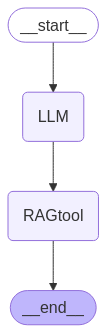

In [81]:
display(Image(app2.get_graph().draw_mermaid_png())) 

In [82]:
app2.invoke({"messages":["what is a meaning of 'cancer from prolonged exposure to burn pits ravaged Heath’s lungs and body'?"]})

"Heath's cancer, which was caused by being around burn pits for a long time, severely damaged his lungs and body."

In [83]:
for output in app2.stream({"messages":["what is a meaning of 'cancer from prolonged exposure to burn pits ravaged Heath’s lungs and body'?"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from LLM
_______
{'messages': ["what is a meaning of 'cancer from prolonged exposure to burn pits ravaged Heath’s lungs and body'?", "Heath's lungs and body were severely damaged by cancer caused by prolonged exposure to burn pits."]}


here is output from RAGtool
_______
Heath's lungs and body were severely damaged by cancer that developed due to long-term exposure to burn pits.




In [1]:
print("all ok")

all ok


In [10]:
loader=DirectoryLoader("../data",glob="./*.txt",loader_cls=TextLoader)
docs=loader.load()
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=50
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

In [12]:
new_docs

[Document(metadata={'source': '..\\data\\japan.txt'}, page_content='Industrial revival hope for Japan'),
 Document(metadata={'source': '..\\data\\japan.txt'}, page_content="Japanese industry is growing faster than expected, boosting hopes that the country's retreat back"),
 Document(metadata={'source': '..\\data\\japan.txt'}, page_content="boosting hopes that the country's retreat back into recession is over."),
 Document(metadata={'source': '..\\data\\japan.txt'}, page_content='Industrial output rose 2.1% - adjusted for the time of year - in January from a month earlier. At'),
 Document(metadata={'source': '..\\data\\japan.txt'}, page_content='of year - in January from a month earlier. At the same time, retail sales picked up faster than at'),
 Document(metadata={'source': '..\\data\\japan.txt'}, page_content='same time, retail sales picked up faster than at any time since 1997. The news sent Tokyo shares to'),
 Document(metadata={'source': '..\\data\\japan.txt'}, page_content='time s

In [11]:
doc_strings

['Industrial revival hope for Japan',
 "Japanese industry is growing faster than expected, boosting hopes that the country's retreat back",
 "boosting hopes that the country's retreat back into recession is over.",
 'Industrial output rose 2.1% - adjusted for the time of year - in January from a month earlier. At',
 'of year - in January from a month earlier. At the same time, retail sales picked up faster than at',
 'same time, retail sales picked up faster than at any time since 1997. The news sent Tokyo shares to',
 'time since 1997. The news sent Tokyo shares to an eight-month high, as investors hoped for a',
 'to an eight-month high, as investors hoped for a recovery from the three quarters of contraction',
 'a recovery from the three quarters of contraction seen from April 2004 on. The Nikkei 225 index',
 'seen from April 2004 on. The Nikkei 225 index ended the day up 0.7% at 11,740.60 points, with the',
 'the day up 0.7% at 11,740.60 points, with the yen strengthening 0.7% again

In [14]:
db = Chroma.from_documents(new_docs, embeddings)

retriever = db.as_retriever(search_kwargs={"k": 3})

In [16]:
query = "Tell me about India's Industrial Growth?"
docs = retriever.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)

{'source': '..\\data\\japan.txt'}
Japan's last four year GDP:


In [17]:
docs

[Document(metadata={'source': '..\\data\\japan.txt'}, page_content="Japan's last four year GDP:"),
 Document(metadata={'source': '..\\data\\japan.txt'}, page_content='quarters of shrinking GDP. Only an exceptionally strong performance in the early months of 2004'),
 Document(metadata={'source': '..\\data\\japan.txt'}, page_content='Industrial revival hope for Japan')]

In [18]:
from typing import TypedDict, Annotated,Sequence

In [19]:
import operator

In [20]:
from langchain_core.messages import BaseMessage

In [ ]:
from langchain.prompts import PromptTemplate

In [25]:
AgentState

{'messages': []}

In [128]:
state={"messages":["hi","how are you?","what is a japan GDP?","which is good model in llm world?"]}

In [ ]:
#last message inside the message list
state["messages"][-1]

'which is good model in llm world?'

In [ ]:
#first message from the message list
state["messages"][0]

'hi'

In [26]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],operator.add]

In [33]:
from langchain_core.messages import HumanMessage

In [34]:
state=AgentState(messages=[HumanMessage(content="hi there")])

In [35]:
state

{'messages': [HumanMessage(content='hi there', additional_kwargs={}, response_metadata={})]}

In [36]:
state=AgentState(messages=["hi"])

In [37]:
state

{'messages': ['hi']}

In [38]:
from pydantic import BaseModel, Field

In [39]:
class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="selected topic")
    Reasoning:str=Field(description="reasoning behind the topic")

In [132]:
pydantic_obj=TopicSelectionParser(Topic="india", Reasoning="india is growing country?")

In [134]:
pydantic_obj.Topic

'india'

In [135]:
pydantic_obj.Reasoning

'india is growing country?'

In [40]:
from langchain.output_parsers import PydanticOutputParser

In [41]:
parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [42]:
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"Topic": {"description": "selected topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "reasoning behind the topic", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}
```


In [ ]:
def function_1(state:AgentState):
    
    message=state["messages"]
    
    question=message[-1] 
    
    print("***********here is my question********")
    print(question)
    
    template="""
    Your task is to classify the given user query into one of the following categories: [Japan, Not Related]. 
    Only respond with the category name and nothing else.

    User query: {question}
    
    {format_instructions}
    """
    
    prompt = PromptTemplate(template=template,
                            input_variables=[question],
                            partial_variables={"format_instructions" : parser.get_format_instructions()}
                            )
    
    chain =prompt | llm | parser
    
    response = chain.invoke({"question":question,"format_instructions" : parser.get_format_instructions() })
    
    print("***********my response********")
    print(response)
    
    return {"messages":[response.Topic]}

In [87]:
state={"messages":["tell me about the japan's industrial growth?"]}

In [85]:
state={"messages":["hi how are you?"]}

In [88]:
function_1(state)

***********my question********
tell me about the japan's industrial growth?
***********my response********
Topic='Japan' Reasoning="The query explicitly asks about Japan's industrial growth."


{'messages': ['Japan']}

In [150]:
def router(state:AgentState):
    print("***********entering into router********")
    print("*********my state from router********")
    print(state)
    
    message=state["messages"]
    
    last_message=message[-1]
    
    print("***********last message********")    
    print(last_message)
    
    if "Japan" in last_message:
        return "RAG Call"
    else:
        return "Simple LLM Call"

In [151]:
def function_2(state:AgentState):
    print("*********my state from function_2(rag)********")
    print(state)
    
    
    print('-> Calling RAG ->')
    
    messages = state['messages']
    
    question = messages[0] ## Fetching the user question
    
    print(question)

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)
    
    print(prompt)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    response={"messages": [result]}
    print("*********my state from function_2(rag)********")
    print(state)
    return response
    

In [152]:
def function_3(state:AgentState):
    print('-> Calling LLM ->')

    messages = state['messages']
    
    question = messages[0] ## Fetching the user question

    # Normal LLM call
    complete_query = "Anwer the follow question with your knowledge of the real world. Following is the user question: " + question
    response = llm.invoke(complete_query)
    response={"messages": [response.content]}
    print("*********my state from function_3(LLM)********")
    print(state)
    return response

In [153]:
from langgraph.graph import StateGraph, END

In [154]:
workflow=StateGraph(AgentState)

In [155]:
workflow.add_node("supervisor",function_1)

In [156]:
workflow.add_node("RAG",function_2)

In [157]:
workflow.add_node("LLM",function_3)

In [158]:
workflow.set_entry_point("supervisor")

In [159]:
workflow.add_conditional_edges(
    "supervisor",
    router,
    {
        "RAG Call": "RAG",
        "Simple LLM Call": "LLM"
    },
    
)

In [160]:
workflow.add_edge("RAG",END)


workflow.add_edge("LLM",END)


app=workflow.compile()

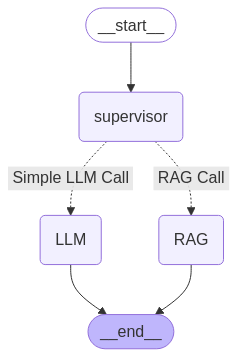

In [161]:
display(Image(app.get_graph().draw_mermaid_png()))

In [162]:
response=app.invoke({"messages":["can you tell me about the japan industrial growth with GDP?"]})

***********my question********
can you tell me about the japan industrial growth with GDP?
***********my response********
Topic='Japan' Reasoning="The query explicitly asks about Japan's industrial growth and GDP."
***********entering into router********
*********my state from router********
{'messages': ['can you tell me about the japan industrial growth with GDP?', 'Japan']}
***********last message********
Japan
*********my state from function_2(rag)********
{'messages': ['can you tell me about the japan industrial growth with GDP?', 'Japan']}
-> Calling RAG ->
can you tell me about the japan industrial growth with GDP?
input_variables=['context', 'question'] input_types={} partial_variables={} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only on the following context:\n    {context}\n\n    Question: {question}\n    '), additional_kwargs={})]
*********my st

In [163]:
response

{'messages': ['can you tell me about the japan industrial growth with GDP?',
  'Japan',
  'Japan experienced three quarters of contraction starting from April 2004, followed by a recovery.  There is also mention of "industrial revival hope".  However, no specific GDP figures or their relationship to industrial growth are provided.']}

In [111]:
response["messages"][-1]

"Japan experienced three quarters of contraction starting from April 2004, followed by a recovery. There are hopes for an industrial revival.  The provided context doesn't give specific GDP numbers or link the recovery directly to industrial growth."

In [125]:
response=app.invoke({"messages":["hi how are you?"]})

***********my question********
hi how are you?
***********my response********
Topic='Not Related' Reasoning='The query is a general greeting and does not mention Japan or any related topics.'
***********my router********
***********last message********
Not Related
-> Calling LLM ->


In [126]:
response["messages"][-1]

"I'm doing well, thank you for asking! How are you?"

In [127]:
for output in app.stream({"messages":["what is a age of donald trump?"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

***********my question********
what is a age of donald trump?
***********my response********
Topic='Not Related' Reasoning="The query asks about Donald Trump's age, which has no relation to Japan."
***********my router********
***********last message********
Not Related
here is output from supervisor
_______
{'messages': ['Not Related']}


-> Calling LLM ->
here is output from LLM
_______
{'messages': ['Donald Trump was born on June 14, 1946.  Therefore, as of October 26, 2023, he is 77 years old.']}




In [ ]:
very useful method for routing in multiagent system
command()